In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

import shapely.wkt
from shapely.geometry import mapping
import ast

In [2]:
results = pd.read_csv("nyc_elections.csv")
results.set_index(["Unit Name", "AD", "ED"], inplace=True)

In [3]:
results.head()

,,,Tally
Unit Name,AD,ED,
Public Counter,65,1,393
Manually Counted Emergency,65,1,0
Absentee / Military,65,1,263
Federal,65,1,7
Special Presidential,65,1,0


In [4]:
candidates = [
  'Joseph R. Biden / Kamala D. Harris (Democratic)',
  'Joseph R. Biden / Kamala D. Harris (Working Families)',
  'Donald J. Trump / Michael R. Pence (Republican)',
  'Donald J. Trump / Michael R. Pence (Conservative)',
  'Howie Hawkins / Angela Nicole Walker (Green)',
  'Jo Jorgensen / Jeremy Cohen (Libertarian)',
  'Brock Pierce / Karla Ballard (Independence)',
]

In [5]:
biden_names = [candidates[0], candidates[1]]
trump_names = [candidates[2], candidates[3]]

In [6]:
biden_results = sum(map(lambda name: results.loc[name], biden_names))
trump_results = sum(map(lambda name: results.loc[name], trump_names))
totals = sum(map(lambda name: results.loc[name], candidates)) + results.loc["Scattered"].reindex(trump_results.index).fillna(0)

In [7]:
biden_percentage = (biden_results / totals).fillna(0)
trump_percentage = (trump_results / totals).fillna(0)
biden_margin = biden_percentage - trump_percentage

In [8]:
modzcta = pd.read_csv("Modified_Zip_Code_Tabulation_Areas__MODZCTA_.csv")

In [9]:
modzcta_polygons = {}
for code, shape in zip(modzcta["MODZCTA"], modzcta["the_geom"]):
  modzcta_polygons[code] = shapely.wkt.loads(shape)

In [10]:
nyed = pd.read_csv("nyed.csv")

In [11]:
nyed_polygons = {}
for code, shape in zip(nyed["ElectDist"], nyed["the_geom"]):
  nyed_polygons[str(code)] = shapely.wkt.loads(shape)

In [12]:
from collections import defaultdict

zipcode_eds = defaultdict(lambda: [])

for (ed, ed_shape) in nyed_polygons.items():
  for (code, zip_shape) in modzcta_polygons.items():
    if zip_shape.contains(ed_shape.representative_point()):
      zipcode_eds[code].append(ed)

In [13]:
biden_margin_for_zipcode = {}
for (code, edcodes) in zipcode_eds.items():
  tot = 0
  biden_votes = 0
  trump_votes = 0
  for edcode in edcodes:
    ad = int(edcode[:2])
    ed = int(edcode[2:])
    if (ad, ed) in totals.index:
      tot += totals.loc[(ad, ed)]["Tally"]
      biden_votes += biden_results.loc[(ad, ed)]["Tally"]
      trump_votes += trump_results.loc[(ad, ed)]["Tally"]

  biden_p = biden_votes / tot if tot > 0 else 0
  trump_p = trump_votes / tot if tot > 0 else 0
  biden_margin_for_zipcode[code] = biden_p - trump_p

In [14]:
covid_latest = pd.read_csv("last7days-by-modzcta.csv")

In [15]:
covid_latest.set_index(["modzcta"], inplace=True)

In [16]:
biden_margins = pd.DataFrame.from_dict(biden_margin_for_zipcode, orient="index").sort_index()
biden_margins.columns = ["biden_margin"]

In [17]:
covid_vs_elections = pd.concat([covid_latest, biden_margins, modzcta.set_index(["MODZCTA"])[["pop_est"]]], axis=1).dropna()

In [18]:
covid_vs_elections["rate_per_100k"] = covid_vs_elections["people_positive"] / covid_vs_elections["pop_est"] * 100000 / 7

<AxesSubplot:xlabel='biden_margin', ylabel='percentpositivity_7day'>

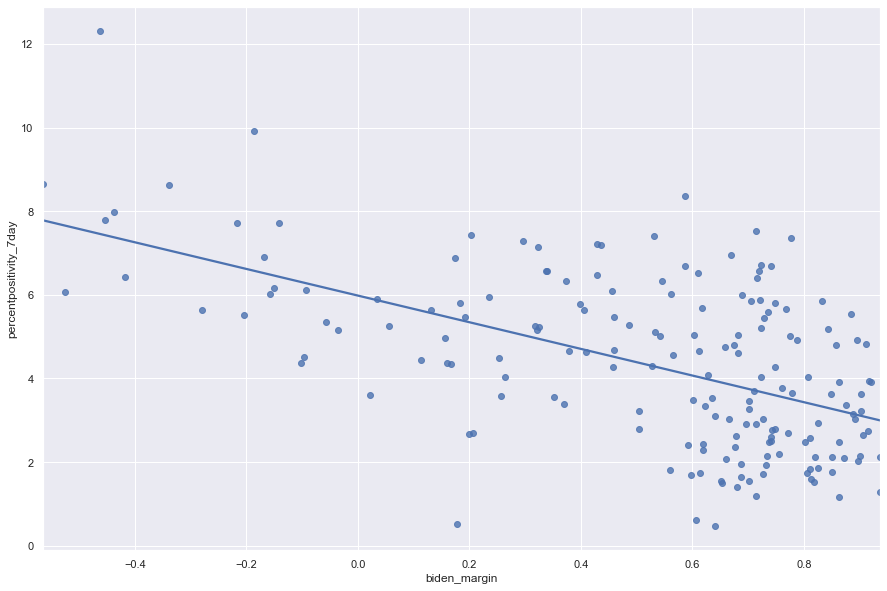

In [19]:
sns.set(rc={'figure.figsize':(15,10)})
sns.regplot(x='biden_margin', y='percentpositivity_7day', data=covid_vs_elections, ci=None, robust=True)

In [20]:
lm = sm.OLS.from_formula("percentpositivity_7day ~ biden_margin", covid_vs_elections).fit()

In [21]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     percentpositivity_7day   R-squared:                       0.312
Model:                                OLS   Adj. R-squared:                  0.308
Method:                     Least Squares   F-statistic:                     79.49
Date:                    Wed, 02 Dec 2020   Prob (F-statistic):           6.27e-16
Time:                            22:49:35   Log-Likelihood:                -344.09
No. Observations:                     177   AIC:                             692.2
Df Residuals:                         175   BIC:                             698.5
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.0436      0.227     26.663      0.000       5.596       6.491
biden_margin    -3.2292      0.362     -8.915      0.000      -3.944      -2.514
==============================================================================
Omnibus:                        2.224   Durbin-Watson:                   1.047
Prob(Omnibus):                  0.329   Jarque-Bera (JB):                2.290
Skew:                           0.250   Prob(JB):                        0.318
Kurtosis:                       2.753   Cond. No.                         3.67
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

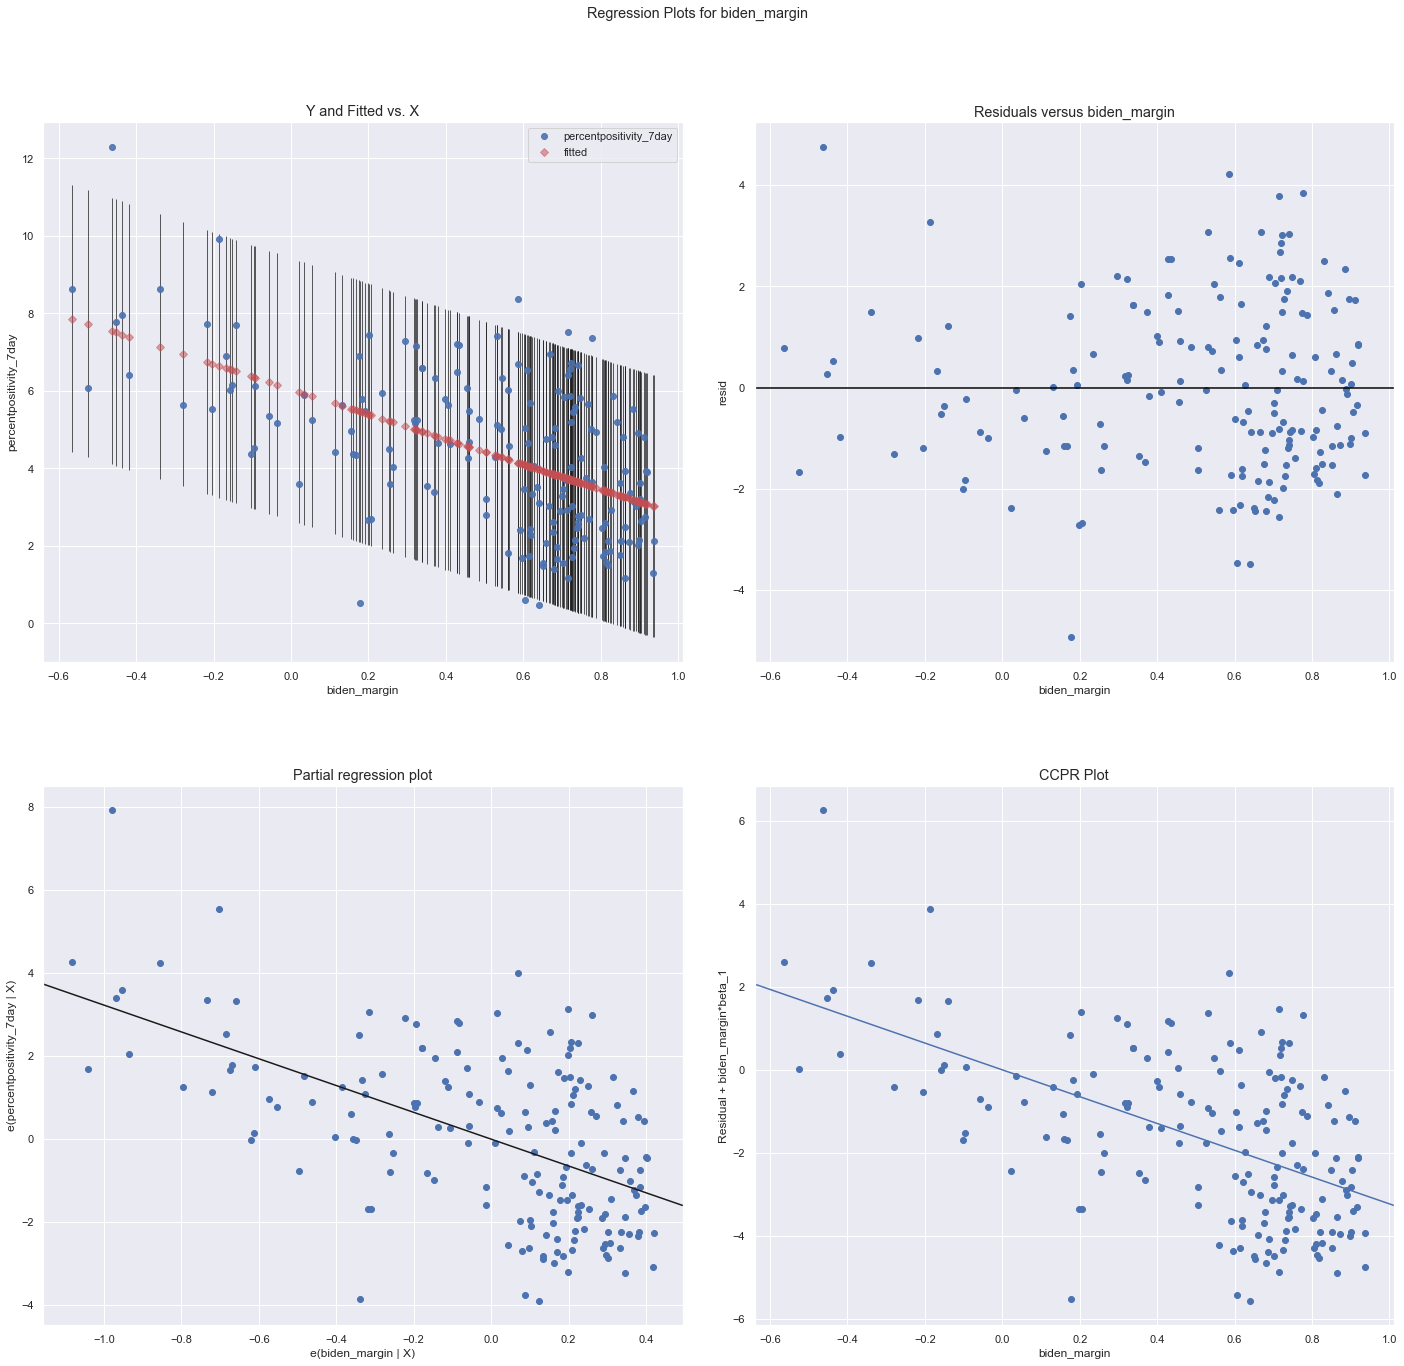

In [22]:
fig = sm.graphics.plot_regress_exog(lm, "biden_margin")
fig.set_size_inches(20, 20)

In [24]:
covid_vs_elections.head()
covid_vs_elections.to_csv('covid_vs_elections.csv')

,modzcta_name,percentpositivity_7day,people_tested,people_positive,median_daily_test_rate,adequately_tested,daterange,biden_margin,pop_est,rate_per_100k
10001,Chelsea/NoMad/West Chelsea,1.94,1184.0,23.0,557.7,Yes,November 23-November 29,0.731209,23072,14.241133
10002,Chinatown/Lower East Side,3.10,2324.0,72.0,426.2,Yes,November 23-November 29,0.641163,74993,13.715566
10003,East Village/Gramercy/Greenwich Village,1.59,2828.0,45.0,487.2,Yes,November 23-November 29,0.812765,54682,11.756284
10004,Financial District,2.35,255.0,6.0,1144.0,Yes,November 23-November 29,0.677162,3028,28.307228
10005,Financial District,1.40,358.0,5.0,388.3,Yes,November 23-November 29,0.680000,8831,8.088390


In [62]:
zip_margin = covid_vs_elections[['modzcta_name','pop_est','biden_margin']]
zip_margin.reset_index(inplace=True)
zip_margin = zip_margin.rename(columns = {'index':'zip'})
zip_margin.head()

,zip,modzcta_name,pop_est,biden_margin
0,10001,Chelsea/NoMad/West Chelsea,23072,0.731209
1,10002,Chinatown/Lower East Side,74993,0.641163
2,10003,East Village/Gramercy/Greenwich Village,54682,0.812765
3,10004,Financial District,3028,0.677162
4,10005,Financial District,8831,0.680000


In [37]:
pp_panel_wide = pd.read_csv("pp_panel_wide.csv")
pp_panel_noaggs = pp_panel_wide.drop(columns=['Bronx', 'Brooklyn','Manhattan','Queens','Staten Island','Citywide'])
pp_panel_noaggs.head()

,End date,10001,10002,10003,10004,10005,10006,10007,10009,10010,...,11432,11433,11434,11435,11436,11691,11692,11693,11694,11697
0,08/31/2020,0.62,0.53,0.28,0.00,1.65,3.06,0.41,0.30,0.59,...,0.92,0.77,0.89,1.26,0.62,2.04,0.51,0.47,0.90,2.02
1,09/01/2020,0.70,0.46,0.34,0.00,1.97,1.98,0.00,0.34,0.55,...,1.02,0.60,0.82,1.47,0.00,2.14,0.49,0.00,0.86,2.94
2,09/02/2020,0.69,0.45,0.29,1.80,2.61,2.97,0.00,0.38,0.36,...,1.05,0.43,0.65,1.46,0.31,2.44,0.26,0.00,0.82,1.83
3,09/03/2020,0.78,0.33,0.40,1.72,2.06,2.86,0.41,0.41,0.40,...,0.95,0.70,0.72,1.57,0.30,2.46,0.26,0.44,0.78,1.92
4,09/04/2020,0.81,0.28,0.35,1.71,2.07,2.91,0.40,0.24,0.33,...,0.68,0.70,0.61,1.16,0.27,2.35,0.26,0.43,0.76,1.80


In [44]:
pp_panel_long = pd.melt(pp_panel_noaggs,id_vars=['End date'], var_name='zip', value_name='positivity_rate')
pp_panel_long.head()

,End date,zip,positivity_rate
0,08/31/2020,10001,0.62
1,09/01/2020,10001,0.70
2,09/02/2020,10001,0.69
3,09/03/2020,10001,0.78
4,09/04/2020,10001,0.81


In [70]:
zip_margin['zip']=zip_margin['zip'].astype(str)
pp_panel_long['zip']=pp_panel_long['zip'].astype(str)
                             
zip_pp_elec_panel = pd.merge(zip_margin, pp_panel_long,
                        how="left", on=["zip", "zip"])
zip_pp_elec_panel.head()
zip_pp_elec_panel.to_csv('zip_pp_elec_panel.csv')